In [88]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

# Global stuff
df_boston = pd.read_csv('./data/boston_2015.csv', dtype={'start_station_id': np.int64, 'end_station_id': 'string', 'end_station_name': 'string', 'start_station_name': 'string', 'bike_id': np.int64, 'user_type': 'string'})
df_boston['start_time'] = pd.to_datetime(df_boston['start_time'], format='%Y-%m-%d %X')
df_boston['end_time'] = pd.to_datetime(df_boston['end_time'], format='%Y-%m-%d %X')
days = [ 'Monday', 'Tuesday', 'Wednesday', 'Thursday', 'Friday', 'Saturday', 'Sunday']
months = ['January', 'February', 'March', 'April', 'May', 'June', 'July', 'August', 'September', 'October', 'November', 'December']

## General Overview of rentals per day over complete year

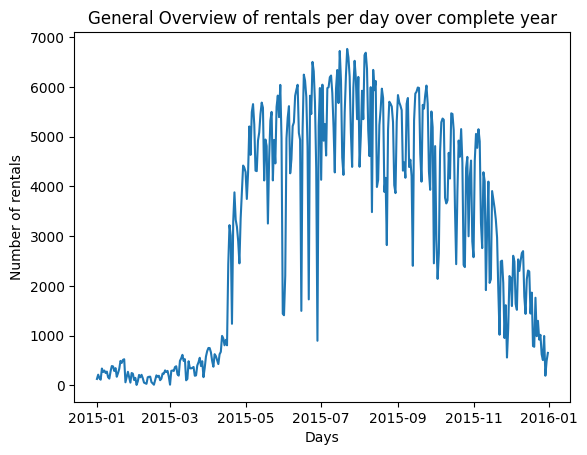

In [89]:
# Data
demand_date = df_boston.groupby(df_boston['start_time'].dt.date)

# Graph
plt.plot(demand_date.size())
plt.xlabel('Days')
plt.ylabel('Number of rentals')
plt.title('General Overview of rentals per day over complete year')
plt.show()

## Rentals per weekday over complete year

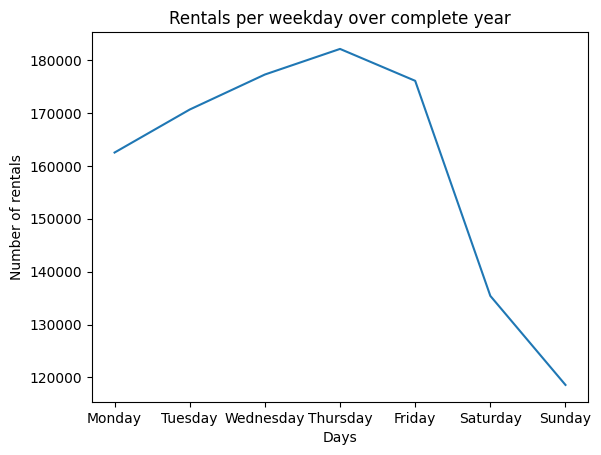

In [90]:
# Data
demand_weekday = df_boston.groupby(df_boston['start_time'].dt.day_name(), sort = True)
grouped_weekdays = demand_weekday.size().reindex(days)

# Graph
plt.plot(grouped_weekdays)
plt.xlabel('Days')
plt.ylabel('Number of rentals')
plt.title('Rentals per weekday over complete year')
plt.show()

## Rentals per week over the year

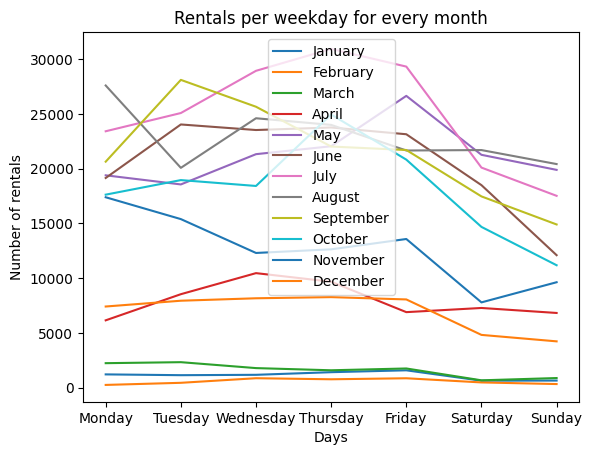

In [91]:
for i in range(1, 13):
    rentals_in_month = df_boston.loc[df_boston['start_time'].dt.month == i]
    demand_of_month_grouped_weekday = df_boston.groupby(rentals_in_month['start_time'].dt.day_name(), sort = True)
    plt.plot(demand_of_month_grouped_weekday.size().reindex(days), label=months[i-1])


plt.xlabel('Days')
plt.ylabel('Number of rentals')
plt.title('Rentals per weekday for every month')
plt.legend()
plt.show()